In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools
from scipy.stats import spearmanr
from itertools import combinations
import seaborn as sns

In [3]:
Stage=3
folder_name='experiment and result stage'+str(Stage)
Dataset="Mnist" #if baseline then Basline .../...
baseline=None

if baseline:
  x=Dataset+" "+baseline
  filename="Copy of " + x + "_result.csv"
else:
  filename="Copy of " + Dataset + "_result.csv"

methods=['deeplift', 'integrated_gradients']
method='deeplift'
flops_dict = {"branch1": 6.272, "branch2": 56.448, "branch3": 157, "totalFLOPS": 416}
end_epoch=0

In [4]:
load_file_path='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/'+filename
print(load_file_path)
save_folder='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/processed data/'
print(save_folder)

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage3/Mnist/Copy of Mnist_result.csv
/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage3/Mnist/processed data/


In [5]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

In [6]:
dataframe

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,branch1.0,branch2.0,branch3.0,branch4.0,train accuracy epoch0,test accuracy epoch0,method,run
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,550.349170,253.373193,384.820020,209.168506,91.866667,97.16,deeplift,0
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,551.079123,253.211756,380.917371,209.168504,91.866667,97.16,integrated_gradients,0
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,537.620850,74.061206,350.337744,133.436084,93.775000,97.08,deeplift,1
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,537.440480,74.054964,349.386515,133.436072,93.775000,97.08,integrated_gradients,1
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,118.538440,146.363098,346.702856,171.171692,92.971667,97.43,deeplift,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,149.765394,164.092863,327.232226,151.657647,94.281667,96.84,integrated_gradients,12
356,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,265.372266,121.834204,335.651855,146.863904,94.226667,96.93,deeplift,13
357,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,265.500795,121.489113,338.330013,146.863896,94.226667,96.93,integrated_gradients,13
358,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,229.307251,102.097266,237.511426,160.454590,94.228333,95.75,deeplift,14


add flops col

In [7]:
def preprocess_dataframe(df, flops_dict):
    df.rename(columns={'branch1.0': 'branch1', 'branch2.0': 'branch2', 'branch3.0': 'branch3', 'branch4.0': 'branch4'}, inplace=True)

    # Add FLOPS columns
    for col, value in flops_dict.items():
        df[col+"FLOPS"] = value
    return df
df = preprocess_dataframe(dataframe, flops_dict)

In [8]:
df

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,branch1,branch2,branch3,branch4,train accuracy epoch0,test accuracy epoch0,method,run,branch1FLOPS,branch2FLOPS,branch3FLOPS,totalFLOPSFLOPS
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,550.349170,253.373193,384.820020,209.168506,91.866667,97.16,deeplift,0,6.272,56.448,157,416
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,551.079123,253.211756,380.917371,209.168504,91.866667,97.16,integrated_gradients,0,6.272,56.448,157,416
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,537.620850,74.061206,350.337744,133.436084,93.775000,97.08,deeplift,1,6.272,56.448,157,416
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,537.440480,74.054964,349.386515,133.436072,93.775000,97.08,integrated_gradients,1,6.272,56.448,157,416
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,118.538440,146.363098,346.702856,171.171692,92.971667,97.43,deeplift,2,6.272,56.448,157,416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,149.765394,164.092863,327.232226,151.657647,94.281667,96.84,integrated_gradients,12,6.272,56.448,157,416
356,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,265.372266,121.834204,335.651855,146.863904,94.226667,96.93,deeplift,13,6.272,56.448,157,416
357,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,265.500795,121.489113,338.330013,146.863896,94.226667,96.93,integrated_gradients,13,6.272,56.448,157,416
358,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,229.307251,102.097266,237.511426,160.454590,94.228333,95.75,deeplift,14,6.272,56.448,157,416


normalize layer feature attribution in this stack

In [9]:
def normalize_feature_attribution(df, threshold=70):
    layers=['branch1','branch2','branch3','branch4']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']


    df.drop(['sum_feature_attr','branch1','branch2','branch3','branch4'], axis=1, inplace=True)

    # delete data with 70 or lower acc
    epoch_3_accuracy_cols = ['test accuracy epoch'+str(end_epoch)]
    df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return df

normalized_df = normalize_feature_attribution(df.copy())

In [10]:
normalized_df

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,train accuracy epoch0,test accuracy epoch0,method,run,branch1FLOPS,branch2FLOPS,branch3FLOPS,totalFLOPSFLOPS,norm_branch1,norm_branch2,norm_branch3,norm_branch4,final_test_accuracy
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,91.866667,97.16,deeplift,0,6.272,56.448,157,416,0.393750,0.181277,0.275322,0.149651,97.16
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,91.866667,97.16,integrated_gradients,0,6.272,56.448,157,416,0.395215,0.181595,0.273181,0.150009,97.16
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,93.775000,97.08,deeplift,1,6.272,56.448,157,416,0.490774,0.067608,0.319810,0.121809,97.08
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,93.775000,97.08,integrated_gradients,1,6.272,56.448,157,416,0.491119,0.067672,0.319273,0.121935,97.08
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,92.971667,97.43,deeplift,2,6.272,56.448,157,416,0.151433,0.186980,0.442914,0.218673,97.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,94.281667,96.84,integrated_gradients,12,6.272,56.448,157,416,0.188919,0.206992,0.412782,0.191306,96.84
356,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,94.226667,96.93,deeplift,13,6.272,56.448,157,416,0.305123,0.140084,0.385930,0.168863,96.93
357,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,94.226667,96.93,integrated_gradients,13,6.272,56.448,157,416,0.304409,0.139293,0.387911,0.168386,96.93
358,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,94.228333,95.75,deeplift,14,6.272,56.448,157,416,0.314391,0.139980,0.325639,0.219991,95.75


get standard deviation for each layer's feature attribution

In [11]:
def get_FA_SD(df, method, flops_dict):
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_branch1','norm_branch2','norm_branch3','norm_branch4']
    accuracy_columns = ['train accuracy epoch'+str(end_epoch), 'test accuracy epoch'+str(end_epoch)]

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var = grouped[layers].var()
    std = grouped[layers].std()
    avg_acc = grouped[accuracy_columns].mean()

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'std_{layer}'] = std[layer]

    # Calculate the average normalized variance across the selected layers
    std_layers = [f'std_{layer}' for layer in layers]
    combined_df['avg_std'] = combined_df[std_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
FA_SD = get_FA_SD(normalized_df, method, flops_dict)

In [12]:
FA_SD.to_csv(save_folder+"/"+method+" "+Dataset+str(baseline)+" all_FA_SD.csv")
FA_SD=pd.read_csv(save_folder+"/"+method+" "+Dataset+str(baseline)+" all_FA_SD.csv")

In [13]:
FA_SD

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_branch1,norm_branch2,norm_branch3,norm_branch4,...,std_norm_branch2,std_norm_branch3,std_norm_branch4,avg_std,train accuracy epoch0,test accuracy epoch0,branch1,branch2,branch3,totalFLOPS
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.203280,0.146641,0.426750,0.223329,...,0.074482,0.095661,0.052273,0.092345,94.275000,97.045333,6.272,56.448,157,416
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.224995,0.191251,0.403544,0.180210,...,0.090090,0.086694,0.036133,0.085176,93.890444,97.020667,6.272,56.448,157,416
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.239354,0.221831,0.378464,0.160351,...,0.089209,0.078292,0.029490,0.079012,93.215000,96.812667,6.272,56.448,157,416
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.245874,0.242705,0.360031,0.151390,...,0.081422,0.067943,0.024933,0.071873,92.073444,96.325333,6.272,56.448,157,416
4,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.016146,0.140164,0.481699,0.361991,...,0.048088,0.065890,0.032487,0.042576,94.547111,96.989333,6.272,56.448,157,416
5,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.109093,0.152432,0.447570,0.290905,...,0.054705,0.071770,0.043330,0.070205,94.384222,97.200000,6.272,56.448,157,416
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.194443,0.171840,0.411843,0.221873,...,0.074504,0.082217,0.042788,0.082678,93.980889,97.218667,6.272,56.448,157,416
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.246592,0.205293,0.371541,0.176574,...,0.083191,0.077901,0.033510,0.080289,93.163667,96.936000,6.272,56.448,157,416
8,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.000528,0.129645,0.484403,0.385424,...,0.047386,0.070202,0.035383,0.038560,94.435333,96.784000,6.272,56.448,157,416
9,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.047386,0.154568,0.456607,0.341439,...,0.054624,0.065217,0.038664,0.058012,94.382444,97.060000,6.272,56.448,157,416


# Graph

In [14]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = ['std_norm_branch1',	'std_norm_branch2',	'std_norm_branch3',	'std_norm_branch4', 'avg_std']

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Standard Deviation for Different {hyperparam} Values')
    plt.ylabel('Standard Deviation')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()

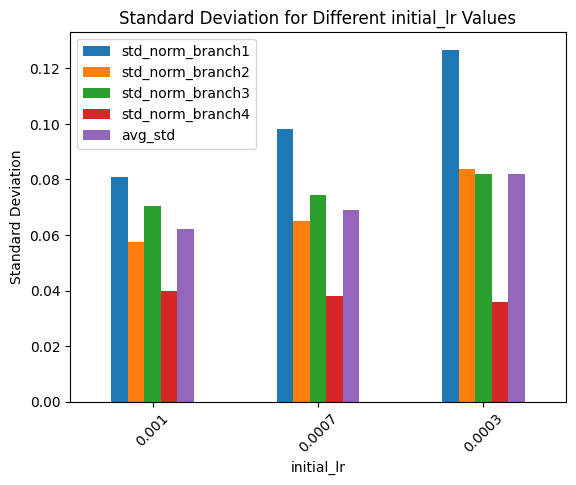

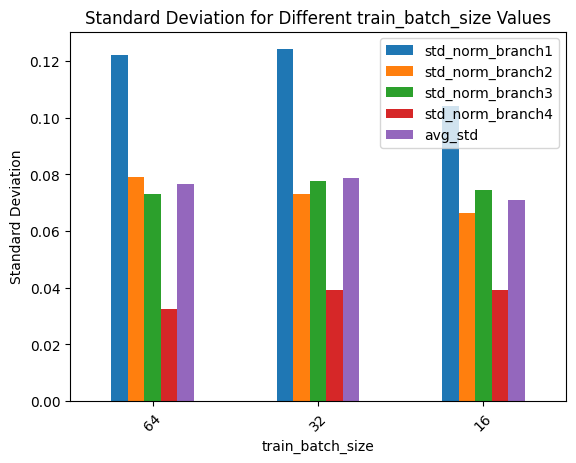

In [15]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(FA_SD, hyperparam, variables)

In [16]:
def plot_bee_swarm_for_norm_fa(df, hyperparam, variables):
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = ['norm_branch1', 'norm_branch2', 'norm_branch3', 'norm_branch4']

    # Preparing data for plotting in long format
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var][variance_columns]
        subset = subset.melt(var_name='Branch', value_name='Variance')
        subset[hyperparam] = var
        plot_data = pd.concat([plot_data, subset])

    # Creating the bee swarm plot
    plt.figure(figsize=(10, 6))
    sns.swarmplot(x=hyperparam, y='Variance', hue='Branch', data=plot_data)
    plt.title(f'Bee Swarm Plot of feature attribution for Different {hyperparam} Values')
    plt.ylabel('Feature Attribution')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.legend(title='Branch')
    plt.show()


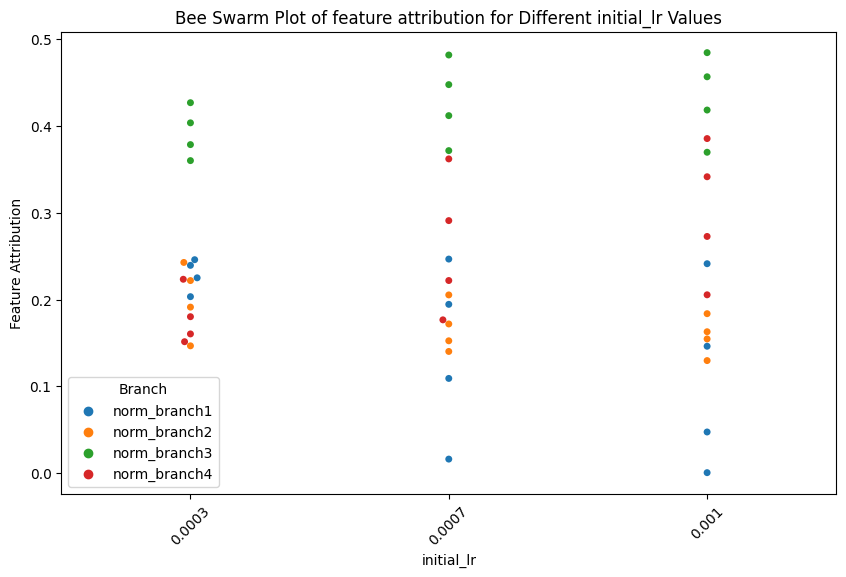

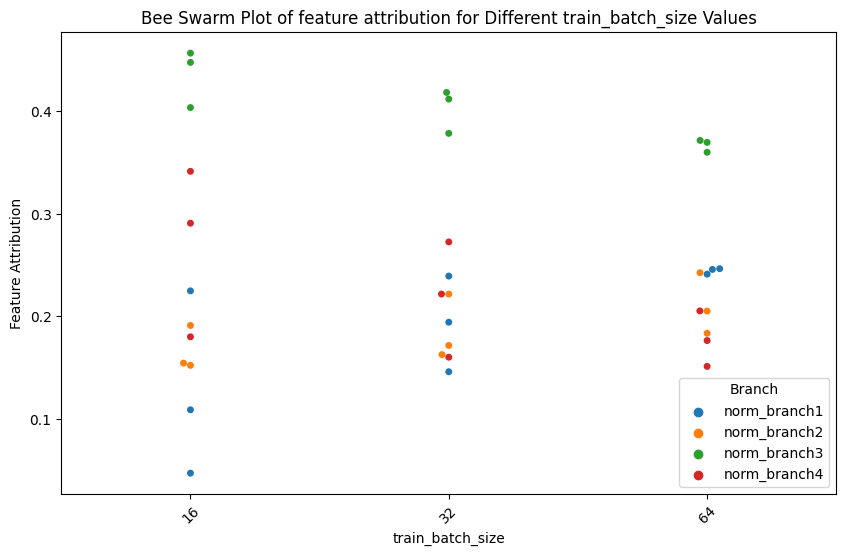

In [17]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_bee_swarm_for_norm_fa(FA_SD, hyperparam, variables)

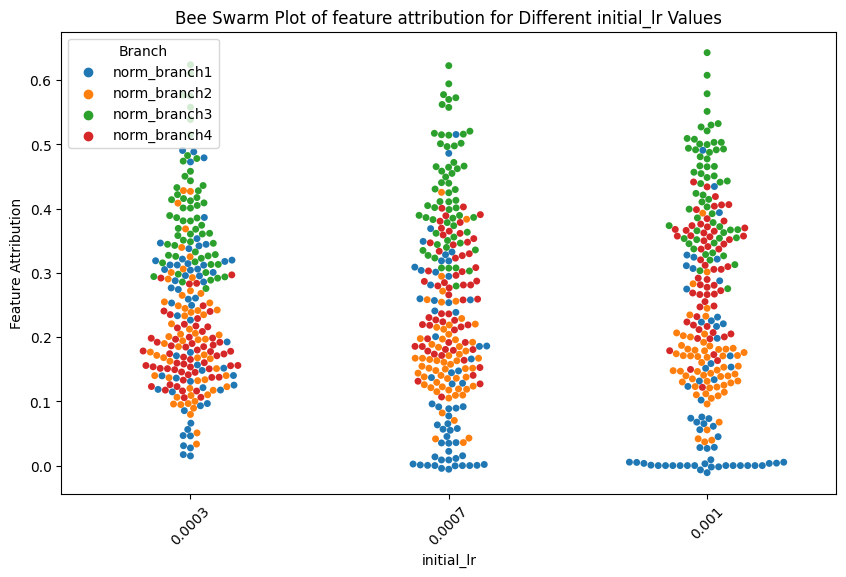

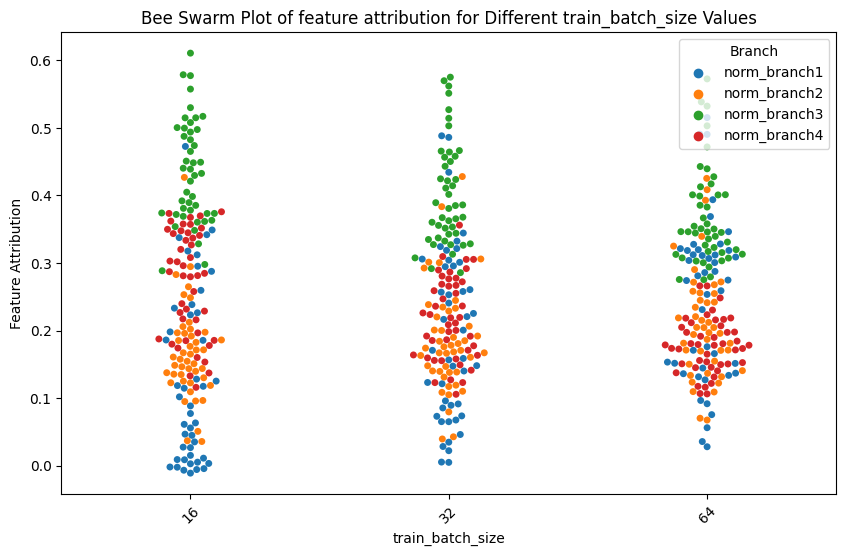

In [18]:
normalized_df_highacc = normalized_df[normalized_df['method'] == method]
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_bee_swarm_for_norm_fa(normalized_df_highacc, hyperparam, variables)

# Paired T test

In [19]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [20]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [21]:
def generate_hyperparameter_combinations(hyperparams):
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [22]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        #print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

In [23]:
hyperparams_choice_list

{'initial_lr': [0.001, 0.0007, 0.0003], 'train_batch_size': [64, 32, 16]}

In [24]:
def get_significant_results(df, hyperparams_choice_list):
  values_to_compare=['std_norm_branch1','std_norm_branch2','std_norm_branch3','avg_std']
  for value in values_to_compare:
    for hyperparam in hyperparams_choice_list:
      lst = hyperparams_choice_list[hyperparam]
      variable_pairs = [(lst[i], lst[j]) for i in range(len(lst)) for j in range(len(lst)) if i != j]
      for variable_pair in variable_pairs:
        data_pairs=get_all_pairs(df, hyperparams_choice_list, value, hyperparam, variable_pair[0], variable_pair[1])
        t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
        #print(value, variable_pair)
        if t_statistic<0:
          #print("not significant\n")
          continue
        if p_value_one_sided>0.01:
          #print("not significant\n")
          continue
        print("Values to compare:", value, "variable_pair:", variable_pair, "T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)
    print("\n")

In [25]:
get_significant_results(FA_SD, hyperparams_choice_list)

#layer feature attribution rank frequency comparison

In [26]:
normalized_df_highacc = normalized_df[normalized_df['method'] == method]

In [27]:
cols_of_interest = ['norm_branch1', 'norm_branch2', 'norm_branch3','norm_branch4']


In [28]:
cols_of_interest = ['norm_branch1', 'norm_branch2', 'norm_branch3','norm_branch4']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-28-799ba4b3762b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


1243    76
3142    30
2143    14
4231    13
1342    11
4132     9
2341     9
1432     7
3241     7
1234     4
Name: rank_combination, dtype: int64